Procesamiento del Lenguaje Natural

## Tecnicatura Universitaria en Inteligencia Artificial

### **Materia: Procesamiento del Lenguaje Natural (IA4.2)**

**Trabajo Práctico N° 2**

**Docentes:**
- D'Alessandro, Ariel
- Geary, Alan
- Leon Cavallo, Andrea
- Manson, Juan Pablo

**Alumno:** Wagner, Juan  (`w-0557/6`)

Año: 2023

## EJERCICIO 1 RAG

Crear un chatbot experto en un tema a elección, usando la técnica RAG (Retrieval Augmented Generation).

Como fuentes de conocimiento se utilizarán al menos las siguientes fuentes:
- Documentos de texto
- Datos numéricos en formato tabular (por ej., Dataframes, CSV, sqlite, etc.)
- Base de datos de grafos (Online o local)


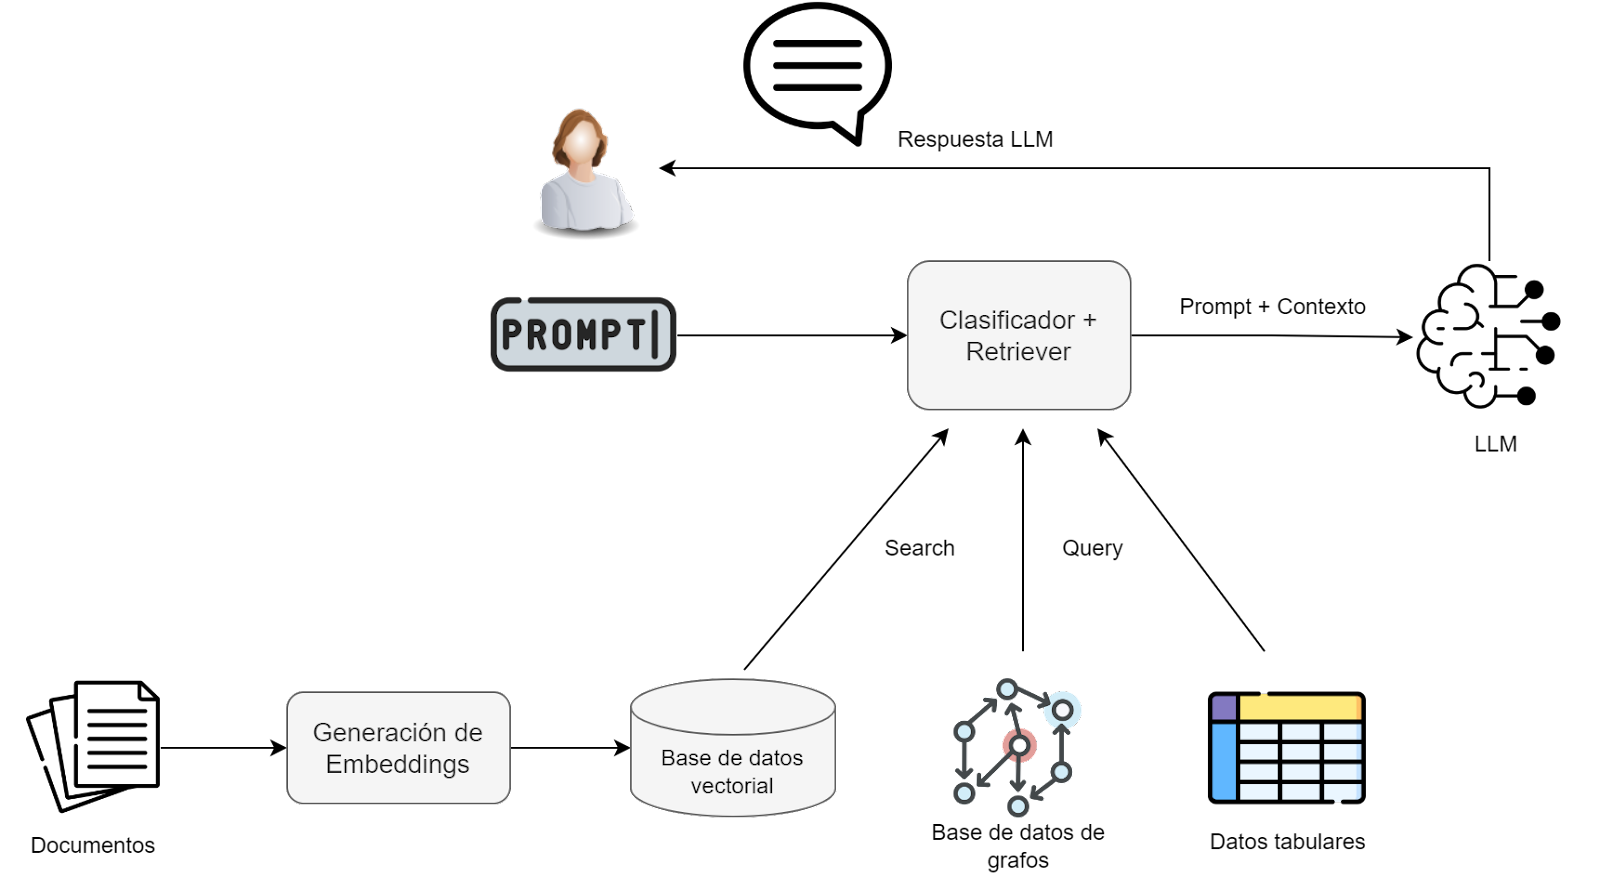


El sistema debe poder llevar a cabo una conversación en lenguaje español. El usuario podrá hacer preguntas, que el chatbot intentará responder a partir de datos de algunas de sus fuentes. El asistente debe poder clasificar las preguntas, para saber qué fuentes de datos utilizar como contexto para generar una respuesta.


Requerimientos generales:

- Realizar todo el proyecto en un entorno Google Colab
- El conjunto de datos debe tener al menos 100 páginas de texto y un mínimo de 3 documentos.
- Realizar split de textos usando Langchain (RecursiveTextSearch, u otros métodos disponibles).
- Limpiar el texto según sea conveniente.
- Realizar los embeddings que permitan vectorizar el texto y almacenarlo en una base de datos ChromaDB
- Los modelos de embeddings y LLM para generación de texto son a elección
Para el desarrollo del “Clasificador” es posible utilizar diversas técnicas aprendidas en la materia, por ejemplo en Unidad 3 y Unidad 6

## Resolucion

In [98]:
!pip install --quiet neo4j langchain_community bs4 langchain chromadb sentence-transformers langchain_openai gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.0 MB/s eta 0:00:00


La DB:
- `normativas_texto.db` contiene todos los textos de las leyes
- `normativas.db` contiene metadata sobre las normativas
- `chroma_db` contiene todos los embedings procesados de los textos de las normativas.

In [1]:
# BASE DE DATOS USADAS
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/My Drive/normativas_texto.db' .
!cp '/content/drive/My Drive/normativas.db' .
!cp -r '/content/drive/My Drive/chroma_db' '/content/chroma_db'

Mounted at /content/drive


Como usamos practicamente todo langchain podemos debugear la ejecucion de las cadenas a traves de langsmith. Ademas, por practicidad de ha optado por usar OpenAI como LLM para procesar los prompts.

In [3]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'tuia'
from google.colab import userdata
os.environ['LANGCHAIN_API_KEY'] = userdata.get("LANGCHAIN_API_KEY")
os.environ['OPENAI_API_KEY'] = userdata.get("OPENAI_API_KEY")

### Contruimos base de datos vectorial

Como vamos a tomar todas las leyes es necesario explorar todo el sitio `https://www.argentina.gob.ar/normativa`

##### Creamos DB Vect `chroma_db`
Buscamos las normativas que ya teniamos descargadas en nuestra base de datos, las fragmentacion en pequeños trozos para ser procesadas por el embedding y luego le agregamos una metadata para poder ubicarla.

In [16]:
# https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.sql_database.SQLDatabaseLoader.html#langchain_community.document_loaders.sql_database.SQLDatabaseLoader
# https://api.python.langchain.com/en/latest/utilities/langchain_community.utilities.sql_database.SQLDatabase.html#langchain_community.utilities.sql_database.SQLDatabase
from langchain_community.document_loaders import SQLDatabaseLoader
from langchain_community.utilities.sql_database import SQLDatabase
from langchain.text_splitter import RecursiveCharacterTextSplitter

query="""SELECT norma_link, norma_numero, norma_año_emision, norma_dependencia, norma_sector, norma_sector_detalle, norma_fecha_sancion, norma_publicacion_voletin_fecha, norma_texto
FROM normativas_texto
WHERE norma_texto IS NOT NULL;"""
loader=SQLDatabaseLoader(query, SQLDatabase.from_uri("sqlite:///normativas_texto.db"), metadata_mapper=lambda x: {c:x[c] for c in x if c!='norma_texto' and x[c]}, page_content_mapper=lambda x: x['norma_texto'])
# Chroma usa 'all-MiniLM-L6-v2' como embedding -> soporta 256 caracteresm como maximo.
splits=loader.load_and_split(RecursiveCharacterTextSplitter(chunk_size=128, chunk_overlap=0))
print(len(splits))
print()
print(splits[0].page_content)
print()
print(splits[0].metadata)

656393

MINISTERIO DE ECONOMÍA
Resolución 70/2024
RESOL-2024-70-APN-MEC
Ciudad de Buenos Aires, 01/03/2024

{'norma_link': '/normativa/nacional/resolución-70-2024-397044', 'norma_numero': 'Resolución   70', 'norma_año_emision': '2024', 'norma_dependencia': 'MINISTERIO DE ECONOMIA', 'norma_sector': 'MINISTERIO DE ECONOMIA', 'norma_sector_detalle': 'RESOLUCION N° 1134/2022 - MODIFICACION', 'norma_fecha_sancion': '01-03-2024', 'norma_publicacion_voletin_fecha': '05-Mar-2024'}


In [17]:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
#https://www.sbert.net/docs/pretrained_models.html
embedding_function = SentenceTransformerEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
# embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

In [18]:
# https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.chroma.Chroma.html#langchain_community.vectorstores.chroma.Chroma
from langchain_community.vectorstores import Chroma
vectorstore=Chroma.from_documents(splits,embedding_function,collection_name="normativas",persist_directory="./chroma_db")

In [19]:
# nos copiamos la db vectorizada para su posterior uso
# !cp -r '/content/chroma_db' '/content/drive/My Drive/chroma_db'

### Componentes del RAG

Antes de enviarse la consulta la modelo de lenguaje se le debe proveer una informacion adicional para que este pueda procesarla adecuamente.

Vamos a usar 3 fuentes de informacion:
1. Una base de datos de conocimiento (grafos) la cual cuenta con todas las normas creadas a partir del 2017 y sus diferentes modificaciones efectudas desde la actualidad hasta el 2020.

In [110]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4", temperature=0)

#### Graph


Ejemplo visual de la base de datos de nodos.

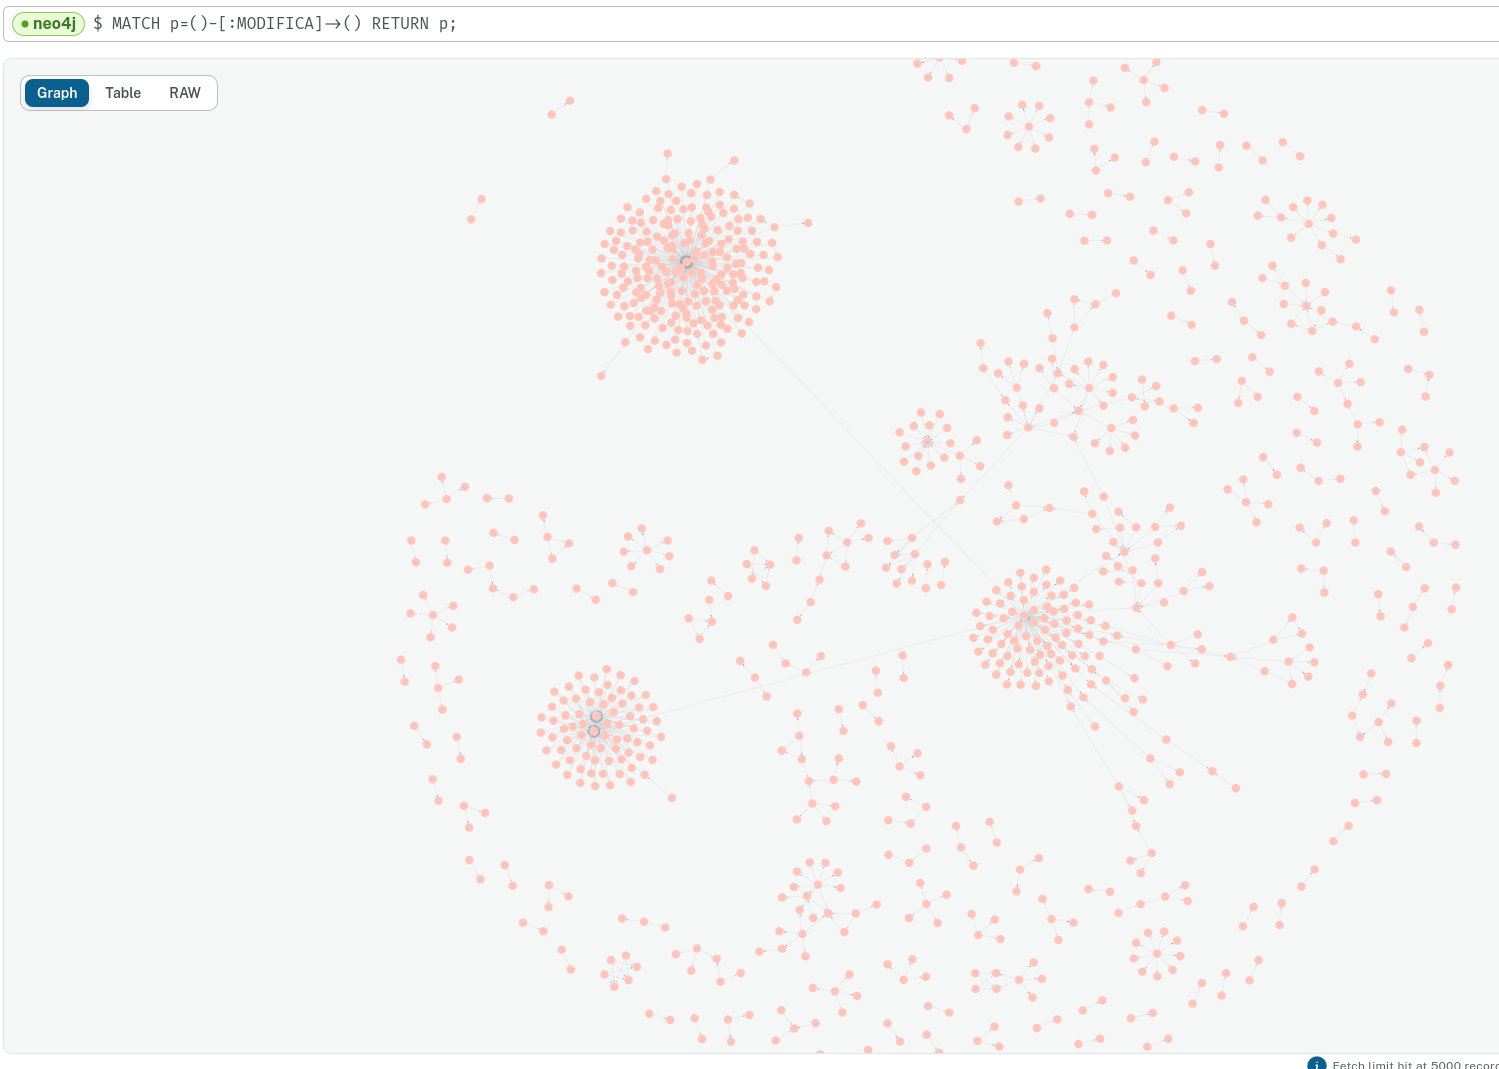


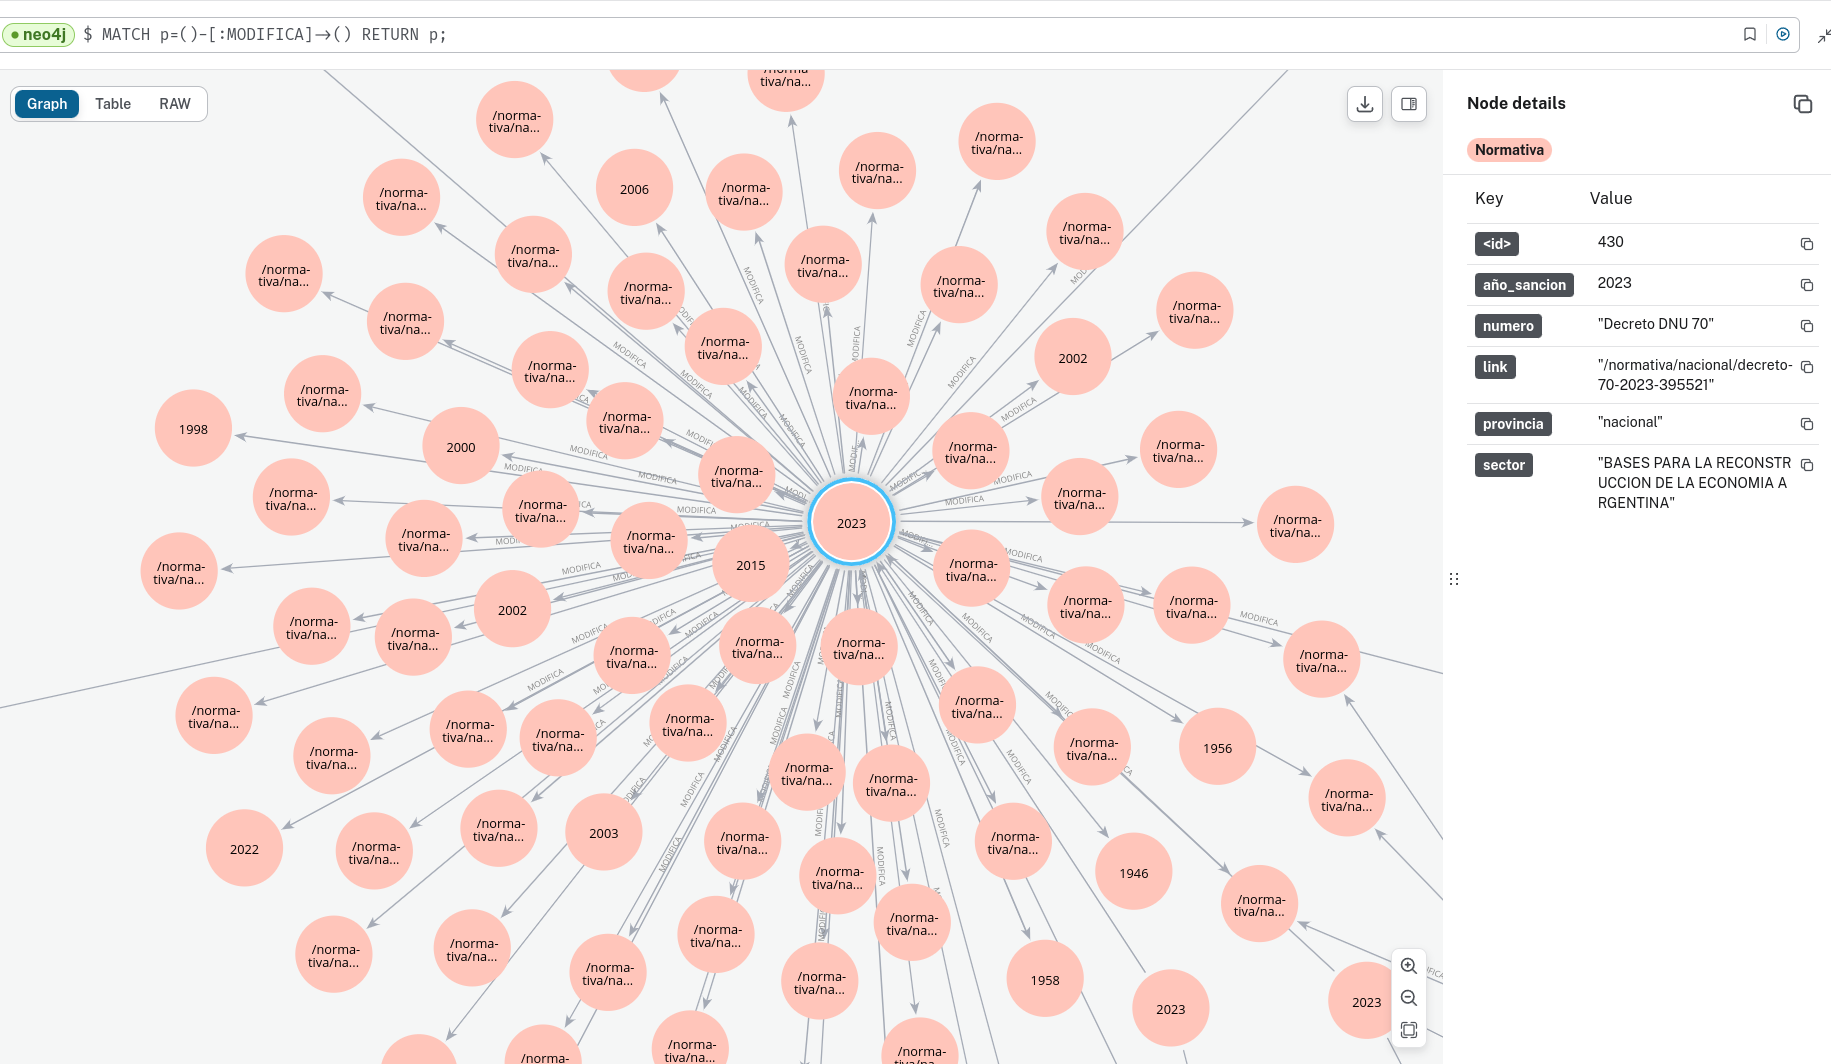

Aqui podemos ver como hay nodos (normativas) que fueron las que han modificado en mayor medida otras, como por ejemplo en este caso el DNU.

In [111]:
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph

In [112]:
graph = Neo4jGraph(
    url=userdata.get('NEO4J_CONN'),
    username=userdata.get('NEO4J_USER'),
    password=userdata.get('NEO4J_PASS')
)
graph.refresh_schema()
print(graph.schema)

Node properties are the following:
Normativa {link: STRING, año_sancion: INTEGER, numero: STRING, provincia: STRING, sector: STRING}
Relationship properties are the following:

The relationships are the following:
(:Normativa)-[:MODIFICA]->(:Normativa)


In [113]:
graph_chain = GraphCypherQAChain.from_llm(llm, graph=graph, return_intermediate_steps=True, return_direct=True)
graph_chain.run("Cuantas Normativas fueron creadas en el año 2024?")

[{'COUNT(n)': 1050}]

#### DB Vectorial

Guarda los embeeding de los fragmentos de las leyes. No he podido procesar todas las leyes por una cuestion de tiempo y dinero.

In [114]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

vectordb = Chroma(persist_directory="./chroma_db",collection_name="normativas",  embedding_function=SentenceTransformerEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2"))
vector_retriever = vectordb.as_retriever()

In [115]:
print(vectordb._collection.count())


656393


#### DB Relacional

Guarda la mayor cantidad de metada posible que ha sido posible obetener del sitio `https://www.argentina.gob.ar/normativa`

In [116]:
from langchain.chains import create_sql_query_chain
from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

db = SQLDatabase.from_uri("sqlite:///normativas.db")

execute_query = QuerySQLDataBaseTool(db=db)
write_query = create_sql_query_chain(llm, db)
relationaldb_chain = write_query | execute_query

In [117]:
relationaldb_chain.invoke({"question":"cuantas normativas hay del año 1999?"})

'[(6942,)]'

## RAG

La logica es simple, se tiene un prompt, y este se envia en simultaneo a diferentes fuentes para que extraigan la informacion relevante que tienen para aportar.

Toda esa informacion se guarda junto al mensaje original para que luego el LLM pueda formulacion una respuesta informada.

In [118]:
from langchain.prompts import ChatPromptTemplate
# basado y aumentado de https://smith.langchain.com/hub/rlm/rag-prompt

template = """Eres un asistente para tareas de preguntas y respuestas (Q&A). Usa los siguientes fragmentos de contexto recuperados para responder a la pregunta. Si no sabes la respuesta, simplemente di que no lo sabes. Usa un máximo de tres frases y mantén la respuesta concisa.

Pregunta:```{question}```

Contexto Neo4j:```{context_neo4j}```

Contexto VectorDB:```{context_vectorDB}```

Contexto relationalDB:```{context_relationalDB}```

Respuesta:"""
QA_CHAIN_PROMPT = ChatPromptTemplate.from_template(template)

In [119]:
from langchain.schema.runnable import RunnableMap
from langchain.schema.output_parser import StrOutputParser

chain = RunnableMap({
    "context_neo4j": lambda x: graph_chain.run(x["question"]),
    "context_vectorDB": lambda x: vectordb.similarity_search(x["question"]),
    "context_relationalDB": lambda x:relationaldb_chain.invoke(x),
    "question": lambda x: x["question"]
}) | QA_CHAIN_PROMPT | llm | StrOutputParser()

In [120]:
r=chain.invoke({"question":"Cuantas normativas hay en el 2023?"})

In [121]:
r

'Hay 17343 normativas en el 2023.'

### Chat RAG

Ultra simple implementacion con gradio para tener una interfaz amigable para chatear.

Este chat NO cuenta con memoria.

In [122]:
import gradio as gr

def reply_rag(message, history):
    return chain.invoke({"question":message})


gr.ChatInterface(reply_rag).launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://eae4b5c2b03ff1ddbb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
